# Plot Compound Years for CESM

You need to run cesmIndeces.ipnyb first

In [1]:
#import my functions
import sys
sys.path.append('../')

#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.overlapBins as overlapBins

In [2]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy.stats

%matplotlib inline

In [3]:
%run utils/emergence.ipynb

In [4]:
#The data
firePos=xarray.open_dataset('results/cesmFirePos.nc').sel(experiment=_model.cesmNoRepeats,drop=True)
fireNeg=xarray.open_dataset('results/cesmFireNeg.nc').sel(experiment=_model.cesmNoRepeats,drop=True)

In [5]:
firePos

<xarray.Dataset>
Dimensions:                (compound: 9, experiment: 13, year: 1250)
Coordinates:
  * year                   (year) int64 850 851 852 853 ... 2096 2097 2098 2099
  * experiment             (experiment) object 'LME.002' 'LME.003' ... '013'
  * compound               (compound) object 'nEvents' 'all3' ... 'anyCompound'
Data variables:
    nino34EastioSamwinter  (compound, experiment, year) float64 ...
    nino34EastioSamsummer  (compound, experiment, year) float64 ...
    nino34DmiSamwinter     (compound, experiment, year) float64 ...
    nino34DmiSamsummer     (compound, experiment, year) float64 ...
Attributes:
    indexNames:  ['nino34', 'eastIO', 'samWinter']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']

# Time of emergence?

Function to calcuate 95% CI from pre-1850 results, and plot against all data.

    Confidence Interval	Z

    90%	1.645

    95%	1.960

In [5]:
rollingFirePos=firePos.sel(
    experiment=_model.cesmNoRepeats, 
    drop=True
).rolling(year=30,min_periods=15,center=True).sum('year')

In [6]:
indexSet='nino34DmiSam'

Plot of trends in individual indices - Fire Promoting

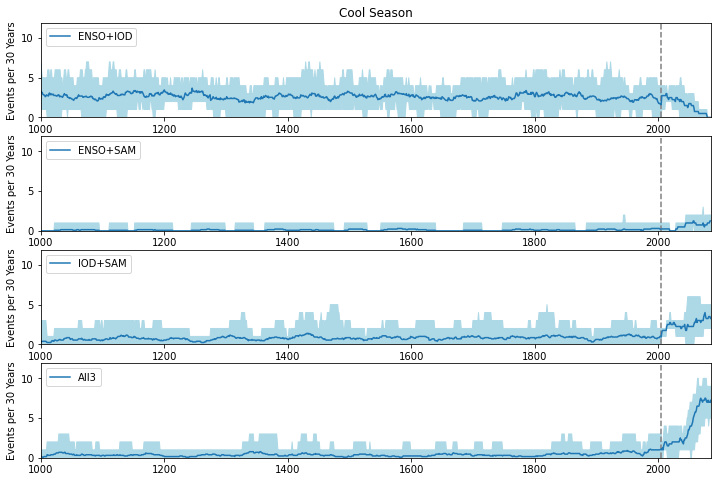

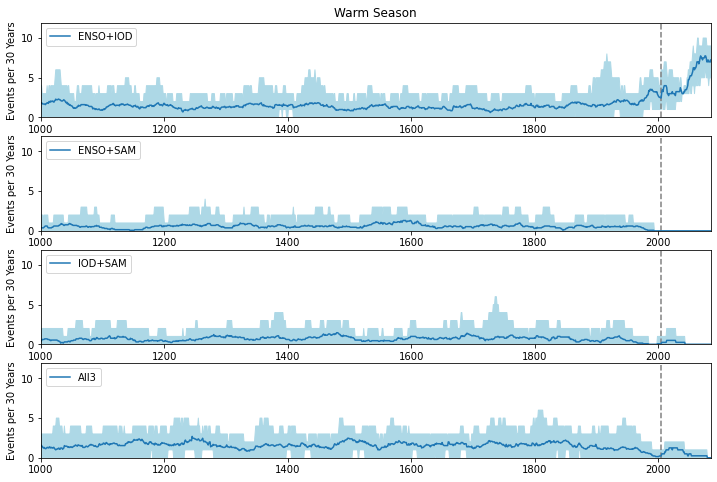

In [13]:
for iSeason in ['winter','summer']:
    plotData=rollingFirePos[indexSet+iSeason].sel(compound=[*firePos.pairs,'all3']).to_dataset('compound')
    ax=emergePlot(
        plotData,
        #plotData.sel(year=slice(850,1850), drop=True)
    )
    
    for axx in ax:
        plt.sca(axx)
        plt.xlim([1000,2085])
        plt.ylim([0,11.9])
        plt.vlines(2005,0,20,color='grey',linestyles='dashed')

    if iSeason=='winter':
        ax[0].set_title('Cool Season')
    elif iSeason=='summer':
        ax[0].set_title('Warm Season')
        
    ax[0].legend(['ENSO+IOD'], loc='upper left')
    ax[1].legend(['ENSO+SAM'], loc='upper left')
    ax[2].legend(['IOD+SAM'], loc='upper left')
    ax[3].legend(['All3'], loc='upper left')


    plt.savefig(
        'figures/cesmDry'+iSeason.capitalize()+'CompoundEmergence.pdf',
        bbox_inches='tight'
    )
    
    plt.show()

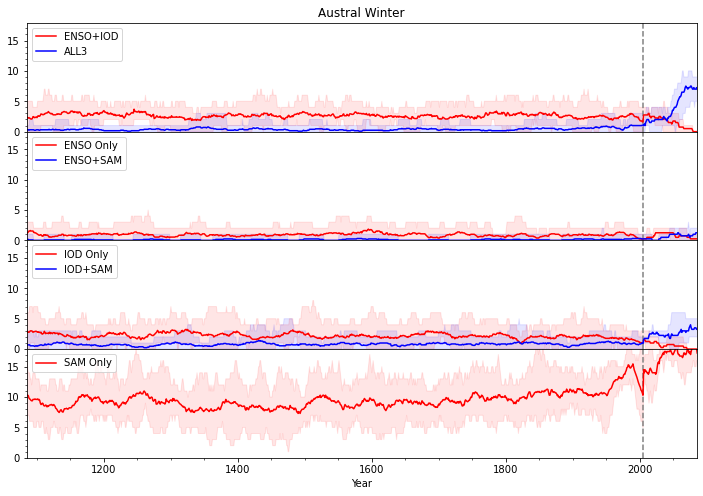

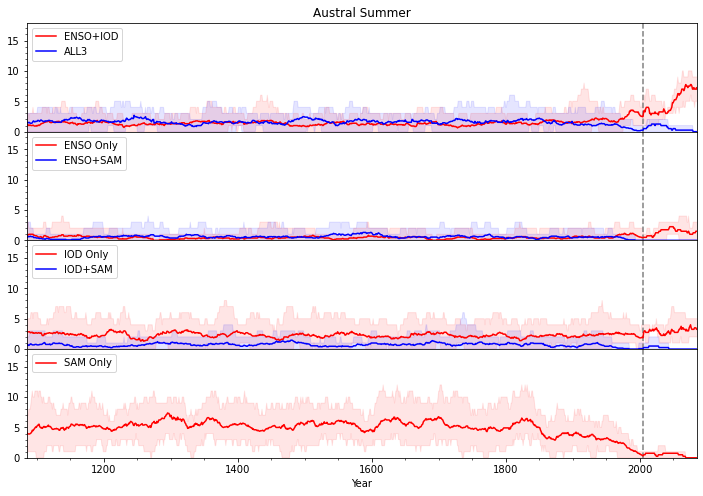

In [71]:
for iSeason in ['winter','summer']:
    plt.figure(figsize=(12,8))
    axx=list()
    iPlot=1
    for indexPair in [
        ['enso+iod','all3'],
        ['enso','enso+sam'],
        ['iod','iod+sam'],
        ['sam']
    ]:
        axx.append(plt.subplot(4,1,iPlot))
        overlaidEmergePlot(
            rollingFirePos[indexSet+iSeason].sel(
                compound=indexPair
            ).to_dataset('compound')
        )
        plt.vlines(2005,0,20,color='grey',linestyles='dashed')
        plt.ylabel('')
        plt.xlim([1085,2085])
        plt.ylim([0,17.9])
        iPlot=iPlot+1

    plt.subplots_adjust(hspace=0)
    axx[0].set_title('Austral '+iSeason.capitalize())

    [ax.set_xticklabels([]) for ax in axx[:-1]]

    axx[0].legend(['ENSO+IOD','ALL3'], loc='upper left')
    axx[1].legend(['ENSO Only','ENSO+SAM'], loc='upper left')
    axx[2].legend(['IOD Only','IOD+SAM'], loc='upper left')
    axx[3].legend(['SAM Only'], loc='upper left')



In [10]:
rollingFireNeg=fireNeg.sel(
    experiment=_model.cesmNoRepeats, 
    drop=True
).rolling(year=30,min_periods=15,center=True).sum('year')

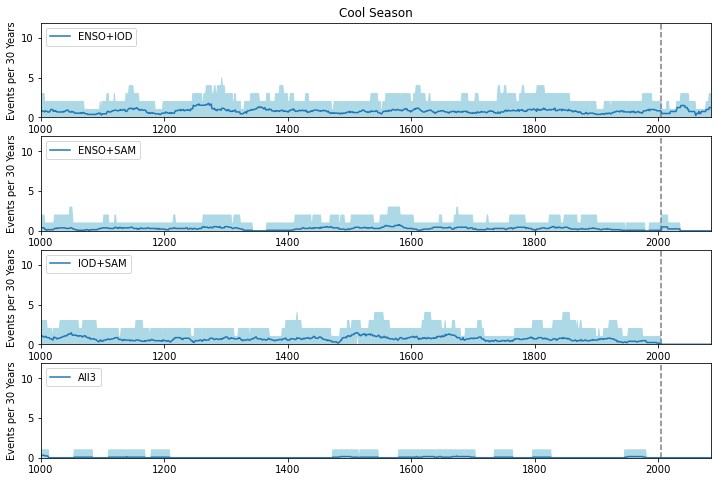

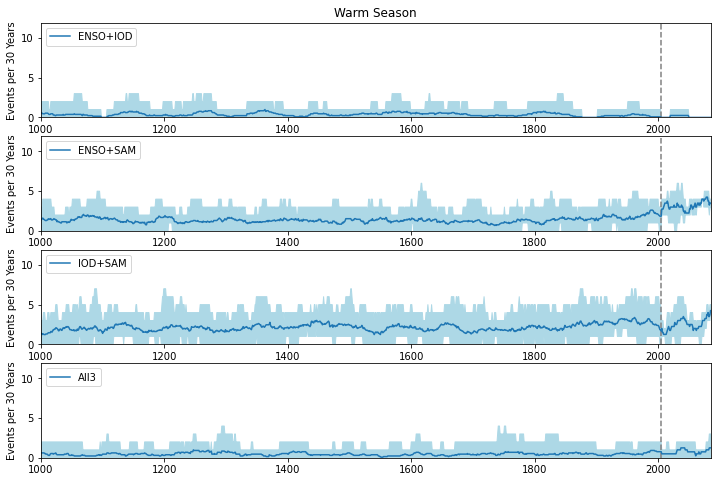

In [14]:
for iSeason in ['winter','summer']:
    plotData=rollingFireNeg[indexSet+iSeason].sel(compound=[*firePos.pairs,'all3']).to_dataset('compound')
    ax=emergePlot(
        plotData,
    )
    
    for axx in ax:
        plt.sca(axx)
        plt.xlim([1000,2085])
        plt.ylim([0,11.9])
        plt.vlines(2005,0,20,color='grey',linestyles='dashed')

    
    if iSeason=='winter':
        ax[0].set_title('Cool Season')
    elif iSeason=='summer':
        ax[0].set_title('Warm Season')    
        
    ax[0].legend(['ENSO+IOD'], loc='upper left')
    ax[1].legend(['ENSO+SAM'], loc='upper left')
    ax[2].legend(['IOD+SAM'], loc='upper left')
    ax[3].legend(['All3'], loc='upper left')


    plt.savefig('figures/cesmWet'+iSeason.capitalize()+'CompoundEmergence.pdf',
        bbox_inches='tight'
    )
    
    plt.show()

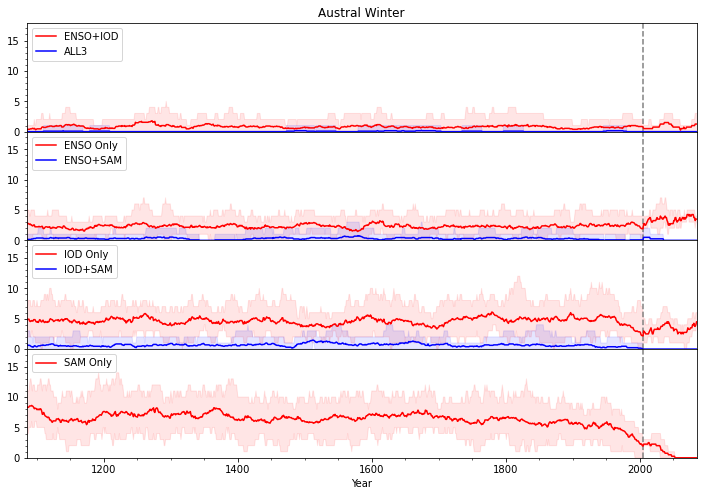

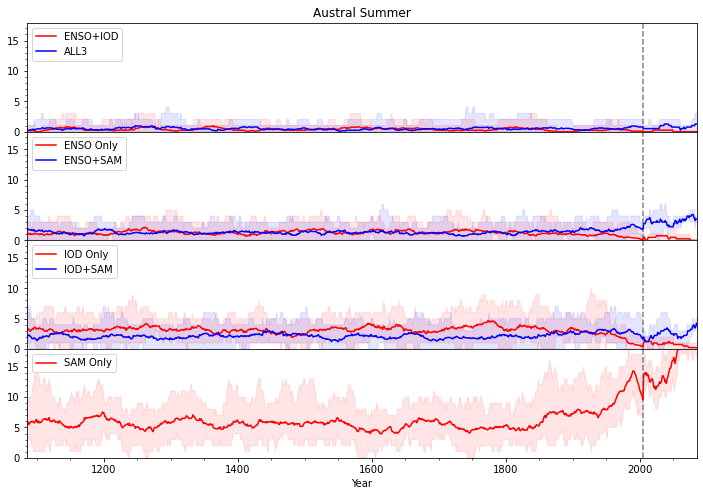

In [73]:
for iSeason in ['winter','summer']:
    plt.figure(figsize=(12,8))
    axx=list()
    iPlot=1
    for indexPair in [
        ['enso+iod','all3'],
        ['enso','enso+sam'],
        ['iod','iod+sam'],
        ['sam']
    ]:
        axx.append(plt.subplot(4,1,iPlot))
        overlaidEmergePlot(
            rollingFireNeg[indexSet+iSeason].sel(
                compound=indexPair
            ).to_dataset('compound')
        )
        plt.vlines(2005,0,20,color='grey',linestyles='dashed')
        plt.ylabel('')
        plt.xlim([1085,2085])
        plt.ylim([0,17.9])
        iPlot=iPlot+1

    plt.subplots_adjust(hspace=0)
    axx[0].set_title('Austral '+iSeason.capitalize())

    [ax.set_xticklabels([]) for ax in axx[:-1]]

    axx[0].legend(['ENSO+IOD','ALL3'], loc='upper left')
    axx[1].legend(['ENSO Only','ENSO+SAM'], loc='upper left')
    axx[2].legend(['IOD Only','IOD+SAM'], loc='upper left')
    axx[3].legend(['SAM Only'], loc='upper left')



# In non-overlapping 30 year bins

Calculate non-overlapping 30 year bins, and sum the number of events in them

In [16]:
firePos

<xarray.Dataset>
Dimensions:                (year: 1250, experiment: 13, compound: 9)
Coordinates:
  * year                   (year) int64 850 851 852 853 ... 2096 2097 2098 2099
  * experiment             (experiment) object 'LME.002' 'LME.003' ... '013'
  * compound               (compound) object 'nEvents' 'all3' ... 'anyCompound'
Data variables:
    nino34EastioSamwinter  (compound, experiment, year) float64 ...
    nino34EastioSamsummer  (compound, experiment, year) float64 ...
    nino34DmiSamwinter     (compound, experiment, year) float64 ...
    nino34DmiSamsummer     (compound, experiment, year) float64 ...
Attributes:
    indexNames:  ['nino34', 'eastIO', 'samWinter']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']

In [17]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

#binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).sum() #This line is a bit problematic. If you have all nans in the bin, it will give you a sum of 0. It is probably more useful to return a nan

#Do the sum for each interval, but only it there are no Nans.
binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).map(
    lambda ds : ds.sum(dim='year').where(ds.isnull().any(dim='year')!=True)
)
binnedFirePos=binnedFirePos.rename({'year_bins':'year'})

binnedFirePos=binnedFirePos.assign_attrs({
        **firePos.attrs,
        'Bins':'Non-Overlapping 30 year bins, seperating by 10 year intervals', 
        'Year':'Midpoint of bin'
    })

In [18]:
#check that years with no data are nan
binnedFirePos.sel(experiment='001')

<xarray.Dataset>
Dimensions:                (year: 41, compound: 9)
Coordinates:
  * year                   (year) int64 875 905 935 965 ... 1985 2015 2045 2075
    experiment             <U3 '001'
  * compound               (compound) object 'nEvents' 'all3' ... 'anyCompound'
Data variables:
    nino34EastioSamwinter  (year, compound) float64 17.0 0.0 3.0 ... nan nan nan
    nino34EastioSamsummer  (year, compound) float64 12.0 1.0 2.0 ... nan nan nan
    nino34DmiSamwinter     (year, compound) float64 17.0 0.0 3.0 ... nan nan nan
    nino34DmiSamsummer     (year, compound) float64 12.0 1.0 2.0 ... nan nan nan
Attributes:
    indexNames:  ['nino34', 'eastIO', 'samWinter']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']
    Bins:        Non-Overlapping 30 year bins, seperating by 10 year intervals
    Year:        Midpoint of bin